# 檢查現有標註資料
## 視覺化 labeldata.csv 並判斷是否可用

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import json
from collections import Counter
import seaborn as sns

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. 載入並檢查 labeldata.csv

In [4]:
# ==================== 請修改路徑 ====================
LABELDATA_CSV = Path('./data/camera/陽光_labeldata.csv')  # 學長留下的檔案
RGB_EXPORT_DIR = Path('./output/rgb_for_labeling')   # 您的 RGB 圖片目錄
SYNCHRONIZED_DIR = Path('./output/synchronized_final')  # 配對資料目錄
# ===================================================

print(f"檢查檔案...")
print(f"  labeldata.csv: {LABELDATA_CSV.exists()}")
print(f"  RGB directory: {RGB_EXPORT_DIR.exists()}")
print(f"  Synchronized directory: {SYNCHRONIZED_DIR.exists()}")

if not LABELDATA_CSV.exists():
    print(f"\n⚠️ 找不到 {LABELDATA_CSV}")
    print("請確認路徑是否正確")
else:
    # 載入
    print(f"\n載入 {LABELDATA_CSV}...")
    
    # 嘗試不同的編碼
    for encoding in ['utf-8', 'big5', 'gbk', 'latin1']:
        try:
            labeldata_df = pd.read_csv(LABELDATA_CSV, encoding=encoding)
            print(f"✓ 成功載入 (編碼: {encoding})")
            break
        except:
            continue
    
    print(f"\n資料形狀: {labeldata_df.shape}")
    print(f"欄位: {list(labeldata_df.columns)}")
    print(f"\n前 10 行:")
    print(labeldata_df.head(10))

檢查檔案...
  labeldata.csv: True
  RGB directory: True
  Synchronized directory: True

載入 data/camera/陽光_labeldata.csv...
✓ 成功載入 (編碼: utf-8)

資料形狀: (1900, 1)
欄位: ['112.000000 116.000000 122.000000 122.000000 124.000000 123.000000 127.000000 124.000000 128.000000 133.000000 128.000000 136.000000 131.000000 129.000000 138.000000 133.000000 136.000000 137.000000 137.000000 140.000000 127.000000 127.000000 125.000000 137.000000 130.000000 125.000000 131.000000 129.000000 125.000000 124.000000 125.000000 122.000000 116.000000 125.000000 121.000000 123.000000 123.000000 119.000000 122.000000 123.000000 120.000000 122.000000 124.000000 130.000000 124.000000 129.000000 131.000000 131.000000 128.000000 135.000000 133.000000 136.000000 135.000000 138.000000 129.000000 136.000000 127.000000 127.000000 128.000000 120.000000 123.000000 126.000000 124.000000 120.000000 110.000000 124.000000 113.000000 117.000000 115.000000 115.000000 126.000000 129.000000 129.000000 125.000000 132.000000 126.000000 130

## 2. 分析標註內容

In [5]:
if LABELDATA_CSV.exists():
    print("="*70)
    print("標註資料分析")
    print("="*70)
    
    # 基本統計
    print(f"\n1. 基本資訊")
    print(f"   總行數: {len(labeldata_df)}")
    print(f"   總欄位: {len(labeldata_df.columns)}")
    
    # 檢查空值
    print(f"\n2. 空值統計")
    null_counts = labeldata_df.isnull().sum()
    if null_counts.sum() > 0:
        print(null_counts[null_counts > 0])
    else:
        print("   ✓ 無空值")
    
    # 顯示所有欄位的資料類型和範例值
    print(f"\n3. 欄位詳情")
    for col in labeldata_df.columns:
        dtype = labeldata_df[col].dtype
        unique_count = labeldata_df[col].nunique()
        sample_values = labeldata_df[col].dropna().head(3).tolist()
        
        print(f"\n   欄位: {col}")
        print(f"     類型: {dtype}")
        print(f"     唯一值數: {unique_count}")
        print(f"     範例值: {sample_values}")
    
    # 如果有數值欄位，顯示統計
    numeric_cols = labeldata_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\n4. 數值欄位統計")
        print(labeldata_df[numeric_cols].describe())
    
    # 如果有類別欄位，顯示分佈
    categorical_cols = labeldata_df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"\n5. 類別欄位分佈")
        for col in categorical_cols[:5]:  # 只顯示前 5 個
            value_counts = labeldata_df[col].value_counts()
            if len(value_counts) < 20:  # 只顯示不超過 20 種類別的
                print(f"\n   {col}:")
                print(value_counts)
    
    print("\n" + "="*70)

標註資料分析

1. 基本資訊
   總行數: 1900
   總欄位: 1

2. 空值統計
   ✓ 無空值

3. 欄位詳情

   欄位: 112.000000 116.000000 122.000000 122.000000 124.000000 123.000000 127.000000 124.000000 128.000000 133.000000 128.000000 136.000000 131.000000 129.000000 138.000000 133.000000 136.000000 137.000000 137.000000 140.000000 127.000000 127.000000 125.000000 137.000000 130.000000 125.000000 131.000000 129.000000 125.000000 124.000000 125.000000 122.000000 116.000000 125.000000 121.000000 123.000000 123.000000 119.000000 122.000000 123.000000 120.000000 122.000000 124.000000 130.000000 124.000000 129.000000 131.000000 131.000000 128.000000 135.000000 133.000000 136.000000 135.000000 138.000000 129.000000 136.000000 127.000000 127.000000 128.000000 120.000000 123.000000 126.000000 124.000000 120.000000 110.000000 124.000000 113.000000 117.000000 115.000000 115.000000 126.000000 129.000000 129.000000 125.000000 132.000000 126.000000 130.000000 129.000000 132.000000 132.000000 131.000000 136.000000 132.000000 129.000000 12

## 3. 判斷標註類型

In [6]:
if LABELDATA_CSV.exists():
    print("\n推測標註類型...\n")
    
    # 檢查可能的標註欄位名稱
    possible_label_cols = []
    
    for col in labeldata_df.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in 
               ['label', 'class', 'category', 'pose', 'action', 'position', 'status', '姿勢', '類別', '標籤']):
            possible_label_cols.append(col)
    
    if possible_label_cols:
        print(f"✓ 可能的標註欄位: {possible_label_cols}\n")
        
        for col in possible_label_cols:
            unique_values = labeldata_df[col].dropna().unique()
            print(f"欄位 '{col}' 的所有值:")
            print(f"  {list(unique_values)}")
            print(f"  總共 {len(unique_values)} 種類別\n")
    else:
        print("⚠️ 未找到明顯的標註欄位")
        print("   可能需要進一步檢查資料格式")
    
    # 檢查是否有座標資訊（可能是 bounding box 或 polygon）
    coord_keywords = ['x', 'y', 'bbox', 'box', 'polygon', 'point', 'coordinate', '座標']
    has_coords = any(any(kw in col.lower() for kw in coord_keywords) 
                     for col in labeldata_df.columns)
    
    if has_coords:
        print("✓ 可能包含座標資訊（物體偵測或分割標註）")
    else:
        print("✓ 可能是影像級別的分類標註")


推測標註類型...

⚠️ 未找到明顯的標註欄位
   可能需要進一步檢查資料格式
✓ 可能是影像級別的分類標註


## 4. 與您的 RGB 圖片對應檢查

In [7]:
if LABELDATA_CSV.exists() and RGB_EXPORT_DIR.exists():
    # 載入您的配對資料
    metadata_file = RGB_EXPORT_DIR / 'labeling_metadata.csv'
    
    if metadata_file.exists():
        your_metadata = pd.read_csv(metadata_file)
        
        print("\n" + "="*70)
        print("對應檢查")
        print("="*70)
        
        print(f"\n您的資料: {len(your_metadata)} 張圖片")
        print(f"學長的標註: {len(labeldata_df)} 筆資料")
        
        # 檢查是否有檔名欄位可以對應
        possible_filename_cols = []
        for col in labeldata_df.columns:
            col_lower = col.lower()
            if any(kw in col_lower for kw in ['file', 'name', 'path', 'image', 'id', '檔名', '圖片']):
                possible_filename_cols.append(col)
        
        if possible_filename_cols:
            print(f"\n可能的檔名欄位: {possible_filename_cols}")
            
            for col in possible_filename_cols:
                print(f"\n{col} 範例:")
                print(labeldata_df[col].head(5).tolist())
        else:
            print("\n⚠️ 未找到明顯的檔名欄位")
        
        # 檢查數量是否匹配
        if len(labeldata_df) == len(your_metadata):
            print(f"\n✓ 數量匹配！學長的標註可能可以直接使用")
        elif len(labeldata_df) > len(your_metadata):
            print(f"\n⚠️ 學長的標註較多 ({len(labeldata_df) - len(your_metadata)} 筆)")
            print("   可能包含您沒有的圖片")
        else:
            print(f"\n⚠️ 您的圖片較多 ({len(your_metadata) - len(labeldata_df)} 張)")
            print("   部分圖片可能需要重新標註")


對應檢查

您的資料: 659 張圖片
學長的標註: 1900 筆資料

⚠️ 未找到明顯的檔名欄位

⚠️ 學長的標註較多 (1241 筆)
   可能包含您沒有的圖片


## 5. 視覺化標註分佈

In [8]:
if LABELDATA_CSV.exists() and possible_label_cols:
    # 選擇主要的標註欄位
    main_label_col = possible_label_cols[0]
    
    print(f"\n視覺化欄位: {main_label_col}")
    
    # 計算分佈
    label_counts = labeldata_df[main_label_col].value_counts()
    
    # 繪圖
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 柱狀圖
    label_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
    axes[0].set_title(f'{main_label_col} 分佈', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('類別', fontsize=12)
    axes[0].set_ylabel('數量', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)
    
    # 在柱子上顯示數量
    for i, (label, count) in enumerate(label_counts.items()):
        axes[0].text(i, count + max(label_counts) * 0.01, str(count), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 圓餅圖
    colors = plt.cm.Set3(range(len(label_counts)))
    axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90, textprops={'fontsize': 11})
    axes[1].set_title(f'{main_label_col} 比例', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('./label_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ 分佈圖已儲存至 ./label_distribution.png")
    
    # 顯示統計
    print(f"\n標註統計:")
    for label, count in label_counts.items():
        percentage = count / len(labeldata_df) * 100
        print(f"  {label:15s}: {count:4d} 筆 ({percentage:5.1f}%)")

## 6. 隨機抽樣視覺化檢查


找到 659 張 RGB 圖片


/tmp/ipykernel_2606698/2458459105.py:37: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2606698/2458459105.py:37: UserWarning: Glyph 25214 (\N{CJK UNIFIED IDEOGRAPH-627E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2606698/2458459105.py:37: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2606698/2458459105.py:37: UserWarning: Glyph 23565 (\N{CJK UNIFIED IDEOGRAPH-5C0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2606698/2458459105.py:37: UserWarning: Glyph 25033 (\N{CJK UNIFIED IDEOGRAPH-61C9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2606698/2458459105.py:37: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2606698/2458459105.py:37: UserWarning: Glyph 35387 (\N{CJK UN

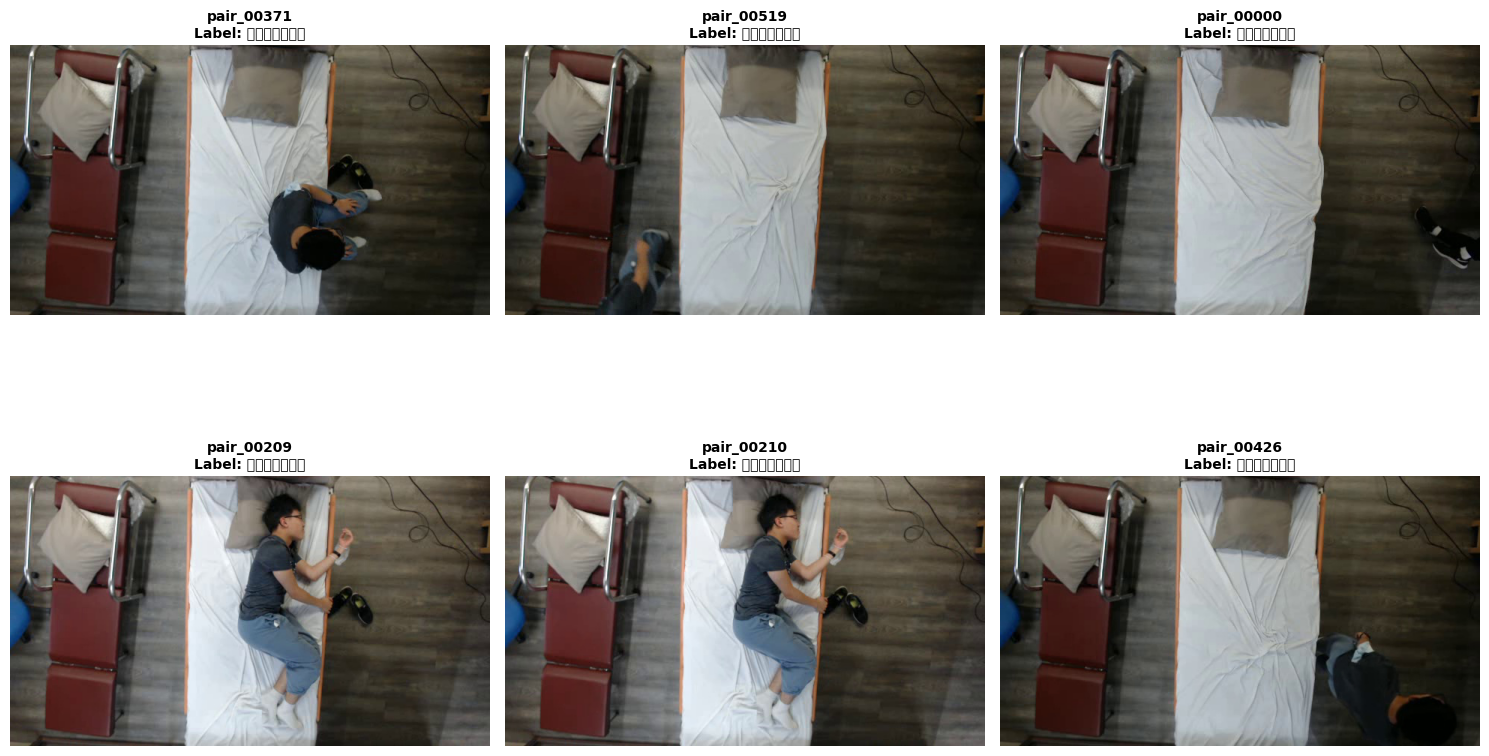


✓ 範例圖已儲存至 ./sample_labeled_images.png


In [9]:
# 如果能對應到圖片，顯示標註結果
if LABELDATA_CSV.exists() and RGB_EXPORT_DIR.exists():
    rgb_dir = RGB_EXPORT_DIR / 'rgb'
    
    if rgb_dir.exists():
        # 取得所有圖片
        rgb_images = sorted(rgb_dir.glob('*.jpg'))
        
        if len(rgb_images) > 0:
            print(f"\n找到 {len(rgb_images)} 張 RGB 圖片")
            
            # 隨機抽 6 張
            num_samples = min(6, len(rgb_images))
            sample_indices = np.random.choice(len(rgb_images), num_samples, replace=False)
            
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            axes = axes.flatten()
            
            for plot_idx, img_idx in enumerate(sample_indices):
                img_path = rgb_images[img_idx]
                img = cv2.imread(str(img_path))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # 嘗試從檔名找對應的標註
                img_name = img_path.stem  # pair_00000
                
                # 如果 labeldata 有對應的 index 欄位
                label_text = "未找到對應標註"
                if img_idx < len(labeldata_df) and possible_label_cols:
                    label_text = str(labeldata_df.iloc[img_idx][possible_label_cols[0]])
                
                axes[plot_idx].imshow(img_rgb)
                axes[plot_idx].set_title(f'{img_name}\nLabel: {label_text}', 
                                        fontsize=10, fontweight='bold')
                axes[plot_idx].axis('off')
            
            plt.tight_layout()
            plt.savefig('./sample_labeled_images.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"\n✓ 範例圖已儲存至 ./sample_labeled_images.png")
        else:
            print("\n⚠️ RGB 目錄中沒有圖片")
    else:
        print(f"\n⚠️ RGB 目錄不存在: {rgb_dir}")

## 7. 生成對應檔案（如果可以對應）

In [10]:
if LABELDATA_CSV.exists() and RGB_EXPORT_DIR.exists():
    metadata_file = RGB_EXPORT_DIR / 'labeling_metadata.csv'
    
    if metadata_file.exists():
        your_metadata = pd.read_csv(metadata_file)
        
        print("\n嘗試生成對應檔案...\n")
        
        # 如果數量匹配，嘗試直接對應
        if len(labeldata_df) == len(your_metadata):
            # 合併資料
            merged = your_metadata.copy()
            
            # 加入學長的標註
            for col in labeldata_df.columns:
                if col not in merged.columns:
                    merged[col] = labeldata_df[col].values
            
            # 儲存
            output_path = RGB_EXPORT_DIR / 'merged_labels.csv'
            merged.to_csv(output_path, index=False)
            
            print(f"✓ 已合併標註！")
            print(f"  儲存至: {output_path}")
            print(f"\n合併後的欄位: {list(merged.columns)}")
            print(f"\n前 5 行預覽:")
            print(merged.head())
        else:
            print("⚠️ 數量不匹配，無法直接合併")
            print("   建議手動檢查對應關係")


嘗試生成對應檔案...

⚠️ 數量不匹配，無法直接合併
   建議手動檢查對應關係


## 8. 總結與建議

In [11]:
print("\n" + "="*70)
print("總結與建議")
print("="*70)

if LABELDATA_CSV.exists():
    print(f"\n✓ 已找到學長的 labeldata.csv")
    print(f"  資料筆數: {len(labeldata_df)}")
    print(f"  欄位數: {len(labeldata_df.columns)}")
    
    if possible_label_cols:
        print(f"\n✓ 已識別標註欄位: {possible_label_cols}")
        main_col = possible_label_cols[0]
        unique_labels = labeldata_df[main_col].nunique()
        print(f"  主要欄位 '{main_col}' 有 {unique_labels} 種類別")
    
    print("\n建議:")
    
    if RGB_EXPORT_DIR.exists() and metadata_file.exists():
        your_count = len(pd.read_csv(metadata_file))
        label_count = len(labeldata_df)
        
        if abs(your_count - label_count) < 10:
            print("  ✓ 數量接近，學長的標註很可能可以使用")
            print("  ✓ 請檢查 merged_labels.csv")
            print("  ✓ 確認標註內容符合您的需求（躺/坐/跌倒）")
        else:
            print(f"  ⚠️ 數量差異較大 (您: {your_count}, 學長: {label_count})")
            print("  ⚠️ 建議手動檢查對應關係")
            print("  ⚠️ 或考慮使用 labelme 重新標註")
    
    print("\n下一步:")
    print("  1. 檢查生成的圖表:")
    print("     - label_distribution.png (標註分佈)")
    print("     - sample_labeled_images.png (範例圖片)")
    print("\n  2. 如果標註可用:")
    print("     - 使用 merged_labels.csv 直接訓練")
    print("\n  3. 如果標註不適用:")
    print("     - 使用 labelme 重新標註")
    print("     - 標註類別建議: lying, sitting, fallen, none")

else:
    print("\n⚠️ 未找到 labeldata.csv")
    print("\n建議:")
    print("  1. 確認檔案路徑是否正確")
    print("  2. 如果確定沒有現成標註，使用 labelme 標註")

print("\n" + "="*70)


總結與建議

✓ 已找到學長的 labeldata.csv
  資料筆數: 1900
  欄位數: 1

建議:
  ⚠️ 數量差異較大 (您: 659, 學長: 1900)
  ⚠️ 建議手動檢查對應關係
  ⚠️ 或考慮使用 labelme 重新標註

下一步:
  1. 檢查生成的圖表:
     - label_distribution.png (標註分佈)
     - sample_labeled_images.png (範例圖片)

  2. 如果標註可用:
     - 使用 merged_labels.csv 直接訓練

  3. 如果標註不適用:
     - 使用 labelme 重新標註
     - 標註類別建議: lying, sitting, fallen, none

